In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [5]:
root_folder = '../build/out/18_withorbit'
meshestxt = root_folder + '/plots/meshes.txt'

In [6]:
run_names = [l[:-1] for l in open(meshestxt, "r").readlines()]

# Load Metrics

In [7]:
# CELL-BASED TRIANGULATION METRICS
run_metrics = {}
run_orbitpoints = {}
for run_name in run_names:
    metrics_file     = os.path.join(root_folder, '{}metrics.csv'.format(run_name))
    orbitpoints_file = os.path.join(root_folder, '{}orbitpoints.csv'.format(run_name))
    
    # print(os.path.exists(metrics_file), os.path.exists(orbitpoints_file))
    run_metrics[run_name] = pd.read_csv(metrics_file)
    run_orbitpoints[run_name] = pd.read_csv(orbitpoints_file)

In [8]:
# HEAT VALUES
run_data = {}
for r_idx, run_name in enumerate(run_names):
    # print('{}/{}'.format(r_idx+1, len(run_names)))
    _, cellSize, rerat, facetSize, lloyd, perturb, exude, regnoise, _, _= run_name.split('_')

    try:
        #print('-----------')
        csv_path = os.path.join(root_folder, 'plots/{}heatvals.csv'.format(run_name))
        # print(csv_path)
        
        origin_index  = pd.read_csv(csv_path, header=None, skiprows=1, nrows=1).values[0][0]
        orbit_indices = list(pd.read_csv(csv_path, header=None, skiprows=3, nrows=1).values[0])
        #print(run_orbitpoints[run_name]['orbit_idx'].sort_values().tolist()[1:])
        #print(orbit_indices)
        # print(list(pd.read_csv(csv_path, header=None, skiprows=3, nrows=1)))
        heat_values   = pd.read_csv(csv_path, skiprows=4)
        
        
        # print(origin_index in orbit_indices)
        # print(orbit_indices == run_orbitpoints[run_name])
        # print(run_orbitpoints[run_name])
        # print(orbit_indices)
        
        # orbit_heat_vals = heat_values.iloc[run_orbitpoints[run_name]['orbit_idx'].sort_values().tolist()[1:]] # heat_values.iloc[orbit_indices]
        orbit_heat_vals = heat_values.iloc[orbit_indices]
        run_data[run_name] = orbit_heat_vals
        
    except:
        print("heat falue file for {} missing".format(run_name))

# CELL-BASED METRICS

In [9]:
def join_run_values(vdict, run_orbitpoints, rnames):
    val_dict = copy.deepcopy(vdict)
    for run_name in rnames:
        _, cellSize, rerat, facetSize, lloyd, perturb, exude, regnoise, _, _ = run_name.split('_')
        n_entries = val_dict[run_name].shape[0]
        lloyd   = bool(int(lloyd))
        perturb = bool(int(perturb))
        exude   = bool(int(exude))
        #nflips  = int(nflips)
        cellSize = float(cellSize)
        facetSize = float(facetSize)
        regnoise = float(regnoise)

        #minorbitpoints = int(minorbitpoints)
        n_orbitpoints = len(run_orbitpoints[run_name]) - 1
        max_shift     = run_orbitpoints[run_name][' moved_by'].max()

        val_dict[run_name]['cellSize'] = [cellSize] * n_entries
        val_dict[run_name]['rerat']    = [rerat]    * n_entries
        val_dict[run_name]['lloyd']    = [lloyd] * n_entries
        val_dict[run_name]['perturb']  = [perturb] * n_entries
        val_dict[run_name]['exude']    = [exude] * n_entries
        # val_dict[run_name]['nflips']   = [nflips] * n_entries
        # val_dict[run_name]['minorbitpoints'] = [minorbitpoints] * n_entries
        val_dict[run_name]['n_orbitpoints'] = [n_orbitpoints] * n_entries
        val_dict[run_name]['max_shift'] = [max_shift] * n_entries
        
        val_dict[run_name]['regnoisefactor'] = [regnoise] * n_entries

    return pd.concat([val_dict[run_name] for run_name in rnames], ignore_index=True)

In [20]:
metric_df = join_run_values(run_metrics, run_orbitpoints, run_names)

In [21]:
metric_df.head()

,minangle,amips,volume,cellSize,rerat,lloyd,perturb,exude,n_orbitpoints,max_shift,regnoisefactor
0,53.9410,26.9581,0.000246,0.1,2,False,False,False,78,0.013629,0.0
1,54.8966,27.9222,0.000228,0.1,2,False,False,False,78,0.013629,0.0
2,40.8167,30.3311,0.000252,0.1,2,False,False,False,78,0.013629,0.0
3,53.7276,39.2103,0.000124,0.1,2,False,False,False,78,0.013629,0.0
4,43.3480,31.8460,0.000192,0.1,2,False,False,False,78,0.013629,0.0


### Metrics BY

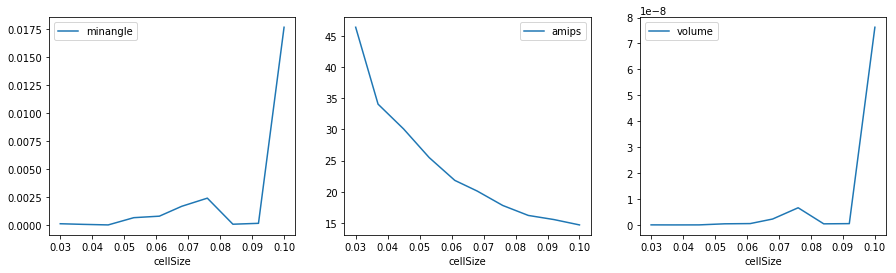

In [12]:
b_var = 'cellSize'
avg_by_size = metric_df.groupby(b_var).min().sort_index()

fig = plt.figure(figsize=(15, 4))
axes = fig.subplots(nrows=1, ncols=3)
avg_by_size.plot(y='minangle', ax=axes[0])
avg_by_size.plot(y='amips',    ax=axes[1])
avg_by_size.plot(y='volume',   ax=axes[2])
plt.show()

# HEAT VALUES

In [13]:
b_var = 'cellSize'
df = join_run_values(run_data, run_orbitpoints, run_names)

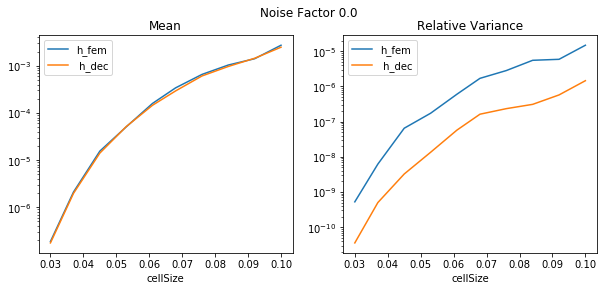

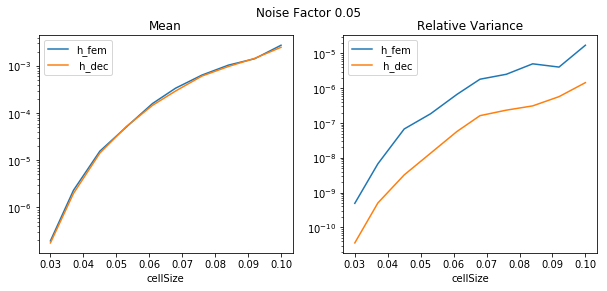

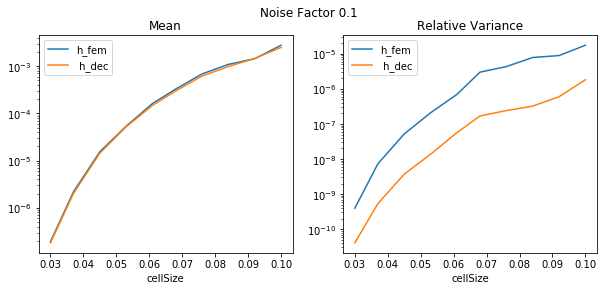

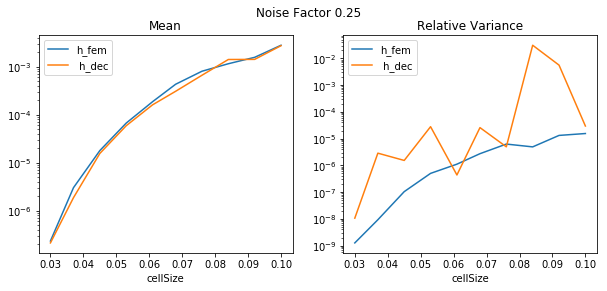

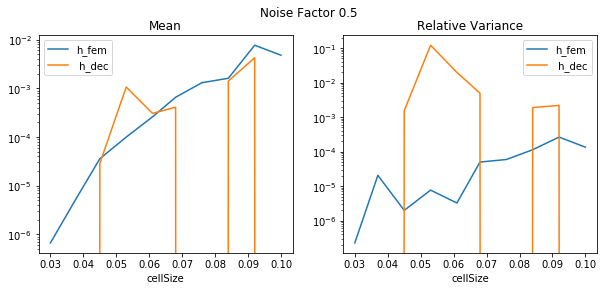

In [14]:
b_var = 'cellSize'

for rnf in df['regnoisefactor'].unique():
    # print('Noise factor {}'.format(rnf))
    data = df[df['regnoisefactor'] == rnf]
    fig = plt.figure(figsize=(10, 4))
    plt.suptitle('Noise Factor {}'.format(rnf))
    axes = fig.subplots(nrows=1, ncols=2)
    data.groupby(b_var)[['h_fem', ' h_dec']].mean().plot(logy=True, ax=axes[0])
    axes[0].set_title('Mean')
    ( (data.groupby(b_var)[['h_fem', ' h_dec']].var()) / (data.groupby(b_var)[['h_fem', ' h_dec']].mean()) 
    ).plot(logy=True, ax=axes[1])
    axes[1].set_title('Relative Variance')
    plt.show()

# Cell Metrics

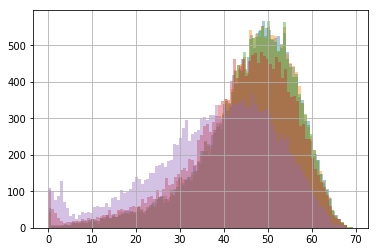

In [18]:
metric_df[metric_df['cellSize'] == 0.1].groupby('regnoisefactor')['minangle'].hist(bins=100, alpha=0.4)
plt.show()

In [38]:
metr

NameError: name 'metr' is not defined

In [33]:
metric_df[metric_df['cellSize'] == 0.084]['minangle'].max()

68.212599999999995